# Text Classification with TREC dataset
# using **Machine Learning Models**

## Library instalation and importation

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import timeit
import string
import seaborn as sns 
import matplotlib.pyplot as plt
from datasets import load_dataset

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score 

# Models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# Metrics
from sklearn.metrics import confusion_matrix, classification_report


## Load data 

In [ ]:
from datasets import load_dataset
df = load_dataset("trec")

  0%|          | 0/2 [00:00<?, ?it/s]

## Function to plot a confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, plot_title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           yticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           title=plot_title, ylabel='Categoria real', xlabel='Categoria predita')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    plt.show()

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    fig, ax = plt.subplots()
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm_normalized.shape[1]),
           yticks=np.arange(cm_normalized.shape[0]),
           xticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           yticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           title=plot_title, ylabel='Categoria real', xlabel='Categoria predita')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], '.0%'),  # Display percentages with 2 decimal places
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > cm_normalized.max() / 2. else "black")

    fig.tight_layout()
    plt.show()

## Functions to preproces the dataset

In [ ]:
# Function to clean text
def clean_text(text):
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  return text

# Function to vectorize text using sklearn
def vectorize1(X):
  # Create the encoder
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,1), stop_words='english')

  # Encode train and test
  X_train = tfidf.fit_transform(X[:5452]).toarray()
  X_test = tfidf.transform(X[5452:]).toarray()

  return X_train, X_test
  
# Function to vectorize text using tensorflow
def vectorize2(X, y_train,vocab_size=8604):

  # Create the encoder with train data
  train_dataset = tf.data.Dataset.from_tensor_slices((X[:5452], y_train))
  encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
  encoder.adapt(train_dataset.map(lambda text, label: text))

  # Encode and pad Train
  X_train = []
  for row in X[:5452]:
    X_train.append(encoder(row).numpy())
  max_len = max([len(x) for x in X_train])
  X_train = [np.pad(x, (0, max_len - len(x)), 'constant') for x in X_train]

  # Encode and pad Test
  X_test = []
  for row in X[5452:]:
    X_test.append(encoder(row).numpy())
  X_test = [np.pad(x, (0, max_len - len(x)), 'constant') for x in X_test]

  return X_train, X_test

# Function to preprocess and vectorize dataset
def preprocess(df, label='coarse_label', vectorize=True):

  y_train = df['train'][label]
  y_test = df['test'][label]
  X = df['train']['text'] + df['test']['text']

  X_cleaned = []
  for sentence in X:
      X_cleaned.append(clean_text(sentence))
      print(X_cleaned)
  if vectorize:
    X_train, X_test = vectorize1(X_cleaned)
  else:
    X_train, X_test = vectorize2(X_cleaned, y_train)

  return X_train, y_train, X_test, y_test

## Function for trainning and evaluating a model

In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, cf=False):
    start = timeit.default_timer()
    model.fit(X_train, y_train)
    stop = timeit.default_timer()
    print(model.__class__.__name__)
    print('Time: ', round(stop - start, 3))  
    print('Acc:  ', model.score(X_test, y_test))
    print()
    y_pred = model.predict(X_test)
    if cf:
      plot_confusion_matrix(y_test, y_pred, 'Matriu de Confusió SGDClassifier')#model.__class__.__name__)

## Preprocess the data and train diferent models

In [ ]:
X_train, y_train, X_test, y_test = preprocess(df, 'coarse_label')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
models = [
    RandomForestClassifier(max_depth= 7,max_features= 10,min_samples_split= 8,n_estimators= 100),
    DecisionTreeClassifier(random_state=0, max_depth=7),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    LinearSVC(C= 0.5, loss='squared_hinge', max_iter= 100, multi_class= 'ovr', penalty='l2', tol= 0.001), 
    Perceptron(alpha= 0.0001, l1_ratio= 0.05,max_iter= 800,n_iter_no_change= 2,penalty= 'elasticnet',tol = 0.01,validation_fraction = 0.1),
    KNeighborsClassifier(n_neighbors=6), # molt rapid acc mitj 0.6
    SGDClassifier(alpha= 0.001,epsilon= 0.01,l1_ratio= 0.15,loss= 'hinge',max_iter= 1000,n_iter_no_change= 8,penalty= 'l2',validation_fraction = 0.2),
    LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001, max_iter=500),  
    BaggingClassifier(KNeighborsClassifier(n_neighbors=3), max_samples=0.5, max_features=0.5), 
    ]

In [ ]:
for model in models:
  train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

RandomForestClassifier
Time:  0.596
Acc:   0.316

DecisionTreeClassifier
Time:  0.406
Acc:   0.206

GradientBoostingClassifier
Time:  48.337
Acc:   0.634

LinearSVC
Time:  0.149
Acc:   0.708

Perceptron
Time:  1.748
Acc:   0.528

KNeighborsClassifier
Time:  0.015
Acc:   0.59

SGDClassifier
Time:  1.757
Acc:   0.716

LogisticRegression
Time:  10.008
Acc:   0.706

BaggingClassifier
Time:  0.346
Acc:   0.628



SGDClassifier
Time:  3.145
Acc:   0.728



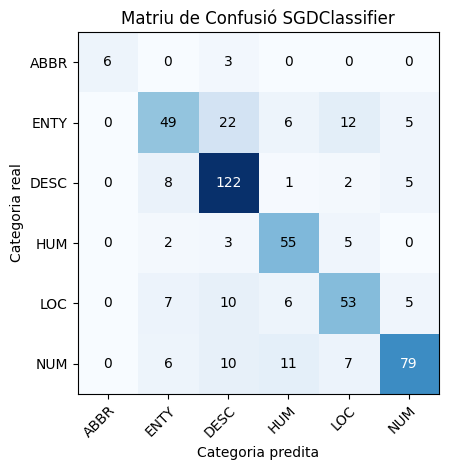

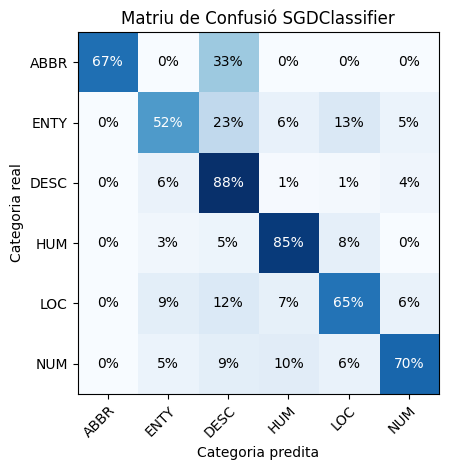

In [ ]:
train_and_evaluate_model(models[6], X_train, y_train, X_test, y_test, True)

## Cross Validation

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  print(model_name)
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  print(accuracies)
  
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
[0.37855179 0.38588451 0.42110092 0.38165138 0.39082569]
DecisionTreeClassifier
[0.31530706 0.30614115 0.30275229 0.30825688 0.30642202]
GradientBoostingClassifier
[0.55820348 0.56186984 0.53577982 0.5587156  0.5440367 ]
LinearSVC
[0.65719523 0.659945   0.62110092 0.63394495 0.62201835]
Perceptron
[0.49495875 0.40696609 0.48165138 0.54311927 0.48715596]
KNeighborsClassifier
[0.46012832 0.47112741 0.44220183 0.46880734 0.45504587]
SGDClassifier
[0.64069661 0.65719523 0.62752294 0.61926606 0.62201835]
LogisticRegression
[0.64711274 0.64619615 0.62477064 0.63394495 0.62201835]
BaggingClassifier
[0.54995417 0.56736939 0.5733945  0.51559633 0.54220183]


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
BaggingClassifier,0.549703,0.022875
DecisionTreeClassifier,0.307776,0.004655
GradientBoostingClassifier,0.551721,0.011260
KNeighborsClassifier,0.459462,0.011633
LinearSVC,0.638841,0.018735
LogisticRegression,0.634809,0.011685
Perceptron,0.482770,0.048881
RandomForestClassifier,0.391603,0.017123
SGDClassifier,0.633340,0.015679


## Hyperparameter search

Random Forest

In [ ]:
model = RandomForestClassifier()
params = {'n_estimators': [90, 100, 120], 
          'max_depth': [3,5,7],
          'max_features': [9,10, 12, 14],
          'min_samples_split': [7,8,9]}

In [ ]:
model_gs = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
model_gs.best_params_

{'max_depth': 7,
 'max_features': 14,
 'min_samples_split': 9,
 'n_estimators': 90}

In [ ]:
model = RandomForestClassifier(max_depth= 7,
 max_features= 10,
 min_samples_split= 8,
 n_estimators= 100).fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[  0,   2,   7,   0,   0,   0],
       [  0,  87,   3,   4,   0,   0],
       [  0, 127,  11,   0,   0,   0],
       [  0,  24,   0,  41,   0,   0],
       [  0,  67,   1,   4,   9,   0],
       [  0,  85,   2,   8,   0,  18]])

LinearSVC

In [ ]:
model = LinearSVC()
params = {'penalty': ['l1', 'l2'],
          'loss': [ 'squared_hinge'],
          'tol': [1e-3, 1e-4],
          'C': [0.35, 0.5, 0.7],
          'multi_class': ['ovr', 'crammer_singer'],
          'max_iter': [90, 100, 110]}
model_gs = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [ ]:
model_gs.best_params_

{'C': 0.35,
 'loss': 'squared_hinge',
 'max_iter': 100,
 'multi_class': 'crammer_singer',
 'penalty': 'l2',
 'tol': 0.001}

XGBoost Classifier

In [ ]:
model = GradientBoostingClassifier()
params = {'n_estimators': [50, 100, 300], 
          'subsample': [0.5, 0.8, 1],
          'max_depth': [3,5,7],
          'learning_rate': [0.1, 0.01, 0.3]}

In [ ]:
model_gs = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
model_gs.best_params_

SGDClassifier

In [ ]:
model = SGDClassifier()
params = {'loss': ['hinge'], 
          'penalty': ['l2'], 
          'alpha': [0.001, 0.0001], 
          'l1_ratio': [0.05, 0.15], 
          'max_iter': [600, 1000], 
          'tol': [0.01, 0.001], 
          'epsilon':[0.01, 0.1, 0.7], 
          'validation_fraction':[0.1, 0.2], 
          'n_iter_no_change': [2, 5, 8]}
model_gs = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
model_gs.best_params_

{'alpha': 0.001,
 'epsilon': 0.01,
 'l1_ratio': 0.15,
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 8,
 'penalty': 'l2',
 'tol': 0.001,
 'validation_fraction': 0.2}

Perceptron

In [ ]:
model = Perceptron()
params = {'penalty': ['l2', 'l1', 'elasticnet'], 
          'alpha': [0.01, 0.001, 0.0001], 
          'l1_ratio': [0.05, 0.15], 
          'max_iter': [800, 1000, 1200], 
          'tol': [0.01, 0.001, 0.0001], 
          'validation_fraction':[0.1, 0.2], 
          'n_iter_no_change': [2, 5, 8]}
model_gs = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


In [ ]:
model_gs.best_params_

{'alpha': 0.0001,
 'l1_ratio': 0.05,
 'max_iter': 800,
 'n_iter_no_change': 2,
 'penalty': 'elasticnet',
 'tol': 0.01,
 'validation_fraction': 0.1}

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Define the hyperparameter grid to search over
params = {'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Instantiate a logistic regression classifier
model = LogisticRegression(random_state=42)

# Perform grid search to find the best hyperparameters
model_gs = GridSearchCV(model, params, scoring=make_scorer(accuracy_score), cv=5).fit(X_train, y_train)

# Output the best hyperparameters and corresponding score
print("Best hyperparameters: ", model_gs.best_params_)
print("Best score: ", model_gs.best_score_)
